<a href="https://colab.research.google.com/github/p2an5/baekjoon/blob/main/0724LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 33.6 MB/s 


In [8]:
import numpy as np
import pandas as pd

# 파이토치 라이브러리 호출
import torch 
import matplotlib.pyplot as plt 

import torchvision 
import torchvision.transforms as transforms 

import torch.nn as nn 
import torch.optim as optim

In [15]:
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

from torch.autograd import Variable 

from torch.utils.data import Dataset, DataLoader

In [2]:
#0724 ver
#데이터 불러오기

import pyupbit
from pyupbit.quotation_api import get_tickers

ETH_price = pyupbit.get_current_price("KRW-ETH")

df_ETH = pyupbit.get_ohlcv("KRW-ETH","hour",1581, to = '20220501')
#220501까지 1581일
#pyupbit.get_ohlcv로 받으면 open, high, low, close, volume거래량, value가 기본으로 있는건지? ->맞는듯

print(df_ETH)

                          open       high        low      close  \
2018-01-01 09:00:00  1028000.0  1076000.0  1011500.0  1057000.0   
2018-01-02 09:00:00  1056500.0  1270500.0  1051000.0  1177000.0   
2018-01-03 09:00:00  1177000.0  1324500.0  1157500.0  1295500.0   
2018-01-04 09:00:00  1295500.0  1518000.0  1269000.0  1439500.0   
2018-01-05 09:00:00  1439500.0  1645000.0  1406500.0  1554500.0   
...                        ...        ...        ...        ...   
2022-04-26 09:00:00  3766000.0  3799000.0  3553000.0  3596000.0   
2022-04-27 09:00:00  3597000.0  3702000.0  3580000.0  3677000.0   
2022-04-28 09:00:00  3677000.0  3786000.0  3646000.0  3737000.0   
2022-04-29 09:00:00  3737000.0  3753000.0  3603000.0  3628000.0   
2022-04-30 09:00:00  3630000.0  3656000.0  3564000.0  3570000.0   

                            volume         value  
2018-01-01 09:00:00   51315.571156  5.381793e+10  
2018-01-02 09:00:00  158481.289301  1.886397e+11  
2018-01-03 09:00:00   83430.944304  1.0099

In [3]:
df_ETH = df_ETH.drop("value",axis=1)
#value는 학습에 쓰는 일이 없어서 먼저 제외

df_ETH = df_ETH.drop(columns='volume')
#이렇게도 삭제 가능

print(df_ETH)

                          open       high        low      close
2018-01-01 09:00:00  1028000.0  1076000.0  1011500.0  1057000.0
2018-01-02 09:00:00  1056500.0  1270500.0  1051000.0  1177000.0
2018-01-03 09:00:00  1177000.0  1324500.0  1157500.0  1295500.0
2018-01-04 09:00:00  1295500.0  1518000.0  1269000.0  1439500.0
2018-01-05 09:00:00  1439500.0  1645000.0  1406500.0  1554500.0
...                        ...        ...        ...        ...
2022-04-26 09:00:00  3766000.0  3799000.0  3553000.0  3596000.0
2022-04-27 09:00:00  3597000.0  3702000.0  3580000.0  3677000.0
2022-04-28 09:00:00  3677000.0  3786000.0  3646000.0  3737000.0
2022-04-29 09:00:00  3737000.0  3753000.0  3603000.0  3628000.0
2022-04-30 09:00:00  3630000.0  3656000.0  3564000.0  3570000.0

[1581 rows x 4 columns]


In [5]:
#결측치 확인
df_ETH.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

In [4]:
X = df_ETH
y = df_ETH.iloc[:, 3:4]

print(X)
print(y)

                          open       high        low      close
2018-01-01 09:00:00  1028000.0  1076000.0  1011500.0  1057000.0
2018-01-02 09:00:00  1056500.0  1270500.0  1051000.0  1177000.0
2018-01-03 09:00:00  1177000.0  1324500.0  1157500.0  1295500.0
2018-01-04 09:00:00  1295500.0  1518000.0  1269000.0  1439500.0
2018-01-05 09:00:00  1439500.0  1645000.0  1406500.0  1554500.0
...                        ...        ...        ...        ...
2022-04-26 09:00:00  3766000.0  3799000.0  3553000.0  3596000.0
2022-04-27 09:00:00  3597000.0  3702000.0  3580000.0  3677000.0
2022-04-28 09:00:00  3677000.0  3786000.0  3646000.0  3737000.0
2022-04-29 09:00:00  3737000.0  3753000.0  3603000.0  3628000.0
2022-04-30 09:00:00  3630000.0  3656000.0  3564000.0  3570000.0

[1581 rows x 4 columns]
                         close
2018-01-01 09:00:00  1057000.0
2018-01-02 09:00:00  1177000.0
2018-01-03 09:00:00  1295500.0
2018-01-04 09:00:00  1439500.0
2018-01-05 09:00:00  1554500.0
...                  

In [10]:
#데이터 정규화
"""
학습이 잘되기 위해 데이터 정규화 
StandardScaler	각 특징의 평균을 0, 분산을 1이 되도록 변경
MinMaxScaler	최대/최소값이 각각 1, 0이 되도록 변경
"""

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mmsc = MinMaxScaler()
stdsc = StandardScaler()

X_std = stdsc.fit_transform(X)
y_mm = mmsc.fit_transform(y) 

In [13]:
# Train Data
X_train = X_std[:1200, :]
X_test = X_std[1200:, :]

# Test Data 
y_train = y_mm[:1200, :]
y_test = y_mm[1200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (1200, 4) (1200, 1)
Testing Shape (381, 4) (381, 1)


In [16]:
#학습할 수 있는 형태로 변환하기 위해 Torch로 변환

"""
torch Variable에는 3개의 형태가 있다. 
data, grad, grad_fn 한 번 구글에 찾아서 공부해보길 바랍니다. 
"""

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 


Training Shape torch.Size([1200, 1, 4]) torch.Size([1200, 1])
Testing Shape torch.Size([381, 1, 4]) torch.Size([381, 1])


In [22]:
#GPU 준비하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
#print(torch.cuda.get_device_name(0)

In [17]:
#LSTM 네트워크 구성하기

class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

#출처: https://coding-yoon.tistory.com/131 [코딩도상국:티스토리]

#위 코드는 복잡해 보이지만, 실상 하나씩 확인해보면 굉장히 연산이 적은 네트워크입니다. 
#시계열 데이터이지만, 간단한 구성을 위해 Sequence Length도 1이고, LSTM Layer도 1이기 때문에 굉장히 빨리 끝납니다. 
#아마 본문 작성자가 CPU환경에서도 쉽게 따라 할 수 있게 간단하게 작성한 것 같습니다. 


In [25]:
#네트워크 파라미터 구성하기 

num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 4 #number of features #수정하면서 하기
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 


In [27]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [28]:
#학습하기

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 


Epoch: 0, loss: 0.01588
Epoch: 100, loss: 0.01204
Epoch: 200, loss: 0.01002
Epoch: 300, loss: 0.00913
Epoch: 400, loss: 0.00879
Epoch: 500, loss: 0.00868
Epoch: 600, loss: 0.00864
Epoch: 700, loss: 0.00861
Epoch: 800, loss: 0.00859
Epoch: 900, loss: 0.00856
Epoch: 1000, loss: 0.00854
Epoch: 1100, loss: 0.00852
Epoch: 1200, loss: 0.00849
Epoch: 1300, loss: 0.00847
Epoch: 1400, loss: 0.00844
Epoch: 1500, loss: 0.00842
Epoch: 1600, loss: 0.00839
Epoch: 1700, loss: 0.00837
Epoch: 1800, loss: 0.00834
Epoch: 1900, loss: 0.00832
Epoch: 2000, loss: 0.00829
Epoch: 2100, loss: 0.00826
Epoch: 2200, loss: 0.00824
Epoch: 2300, loss: 0.00821
Epoch: 2400, loss: 0.00818
Epoch: 2500, loss: 0.00815
Epoch: 2600, loss: 0.00812
Epoch: 2700, loss: 0.00808
Epoch: 2800, loss: 0.00804
Epoch: 2900, loss: 0.00800
Epoch: 3000, loss: 0.00796
Epoch: 3100, loss: 0.00791
Epoch: 3200, loss: 0.00786
Epoch: 3300, loss: 0.00780
Epoch: 3400, loss: 0.00774
Epoch: 3500, loss: 0.00767
Epoch: 3600, loss: 0.00761
Epoch: 3700, 

In [30]:
#예측하기

df_X_ss = stdsc.transform(df_ETH)
df_y_mm = mmsc.transform(df_ETH.iloc[:, 3:4])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

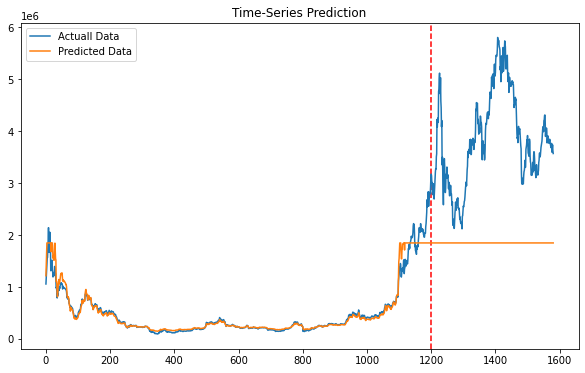

In [33]:
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mmsc.inverse_transform(data_predict) #reverse transformation
dataY_plot = mmsc.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=1200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 
